In [1]:
import sys
sys.path.append('..')
from MPRA_predict.utils import *

In [4]:
subprocess.run([
    'python', 'train_scripts/test_1110.py', 
    '-s', 'saved/1111_Gosai_MPRA_MyResTrans_seq_Sei_VEF/1110_135744/', 
    '-c', 'configs/config_1111_Gosai_MPRA_MyResTrans_seq_Sei_VEF_TFBU.yaml',
    '-o', 'TFBU_MPRA_pred.npy'],
    cwd='..'
)

use new config: configs/config_1111_Gosai_MPRA_MyResTrans_seq_Sei_VEF_TFBU.yaml


100%|██████████| 5/5 [00:01<00:00,  3.44it/s]


CompletedProcess(args=['python', 'train_scripts/test_1110.py', '-s', 'saved/1111_Gosai_MPRA_MyResTrans_seq_Sei_VEF/1110_135744/', '-c', 'configs/config_1111_Gosai_MPRA_MyResTrans_seq_Sei_VEF_TFBU.yaml', '-o', 'TFBU_MPRA_pred.npy'], returncode=0)

In [9]:
subprocess.run([
    'python', 'train_scripts/test_1110.py', 
    '-s', 'saved/1110_Gosai_MPRA_MyResTrans_seq/1110_055401/', 
    '-c', 'configs/config_1110_Gosai_MPRA_MyResTrans_seq_TFBU.yaml',
    '-o', 'TFBU_MPRA_pred.npy'],
    cwd='..'
)

use new config: configs/config_1110_Gosai_MPRA_MyResTrans_seq_TFBU.yaml


100%|██████████| 5/5 [00:00<00:00,  5.30it/s]


CompletedProcess(args=['python', 'train_scripts/test_1110.py', '-s', 'saved/1110_Gosai_MPRA_MyResTrans_seq/1110_055401/', '-c', 'configs/config_1110_Gosai_MPRA_MyResTrans_seq_TFBU.yaml', '-o', 'TFBU_MPRA_pred.npy'], returncode=0)

In [2]:
cell_types = ['HepG2', 'HEK293T', 'Jurkat', 'PANC-1', 'HeLa-S3']

In [3]:
MPRA_df = pd.read_csv('../data/TFBU_MPRA/TFBU_MPRA.tsv', sep='\t')
MPRA_df[cell_types] = (MPRA_df[cell_types] - MPRA_df[cell_types].mean()) / MPRA_df[cell_types].std()
MPRA_df.describe()

,HepG2,HEK293T,Jurkat,PANC-1,HeLa-S3
count,16911.000,16942.000,16106.000,16949.000,16795.000
mean,-0.000,-0.000,0.000,-0.000,0.000
std,1.000,1.000,1.000,1.000,1.000
min,-1.603,-2.112,-3.040,-2.388,-3.542
25%,-0.719,-0.662,-0.647,-0.704,-0.609
50%,-0.358,-0.354,-0.232,-0.273,-0.271
75%,0.434,0.299,0.430,0.452,0.295
max,5.607,7.365,4.858,10.823,13.317


In [5]:
data_split_dict = {}

data_split_dict['total'] = np.ones(len(MPRA_df), dtype=bool)

for cell_type in cell_types:
    ref_mean = MPRA_df[cell_types].mean(axis=1)
    diff = (MPRA_df[cell_type] - ref_mean).abs()
    threshold = np.percentile(diff.dropna(), 90)
    data_split_dict[f'{cell_type}_specific'] = diff > threshold

    threshold = np.percentile(MPRA_df[cell_type].dropna(), 90)
    data_split_dict[f'{cell_type}_high'] = MPRA_df[cell_type] > threshold

    threshold = np.percentile(MPRA_df[cell_type].dropna(), 10)
    data_split_dict[f'{cell_type}_low'] = MPRA_df[cell_type] < threshold



HH_diff = (MPRA_df['HEK293T'] - MPRA_df['HepG2']).abs()
HH_threshold = np.percentile(HH_diff.dropna(), 90)
data_split_dict[f'HH_specific'] = HH_diff > HH_threshold



for key in data_split_dict:
    print(key, data_split_dict[key].sum())

keys = list(data_split_dict.keys())
for k1 in keys:
    for k2 in keys:
        data_split_dict[f'{k1}+{k2}'] = data_split_dict[k1] & data_split_dict[k2]

total 18000
HepG2_specific 1691
HepG2_high 1691
HepG2_low 1691
HEK293T_specific 1695
HEK293T_high 1695
HEK293T_low 1695
Jurkat_specific 1611
Jurkat_high 1611
Jurkat_low 1611
PANC-1_specific 1695
PANC-1_high 1695
PANC-1_low 1695
HeLa-S3_specific 1680
HeLa-S3_high 1680
HeLa-S3_low 1680
HH_specific 1691


In [6]:
y_pred = np.load('../saved/1111_Gosai_MPRA_MyResTrans_seq_Sei_VEF/1110_135744/TFBU_MPRA_pred.npy')
pred_cols = [f'{cell_type}_pred' for cell_type in cell_types]
MPRA_df[pred_cols] = y_pred

In [7]:
y_pred = np.load('../saved/1110_Gosai_MPRA_MyResTrans_seq/1110_055401/TFBU_MPRA_pred.npy')
# HepG2 K562 SK-H-SH 的预测平均值
MPRA_df['mean_pred'] = y_pred.mean(axis=1)

In [9]:
for data_split in ['total', 'HH_specific']:
    pearson_df = pd.DataFrame()
    for c1 in cell_types:
        for c2 in cell_types+['mean']:
            if data_split in ['specific', 'high', 'low']:
                cond = data_split_dict[f'{c1}_{data_split}']
            else:
                cond = data_split_dict[data_split]
            x = MPRA_df.loc[cond, f'{c1}']
            y = MPRA_df.loc[cond, f'{c2}_pred']
            r, p = pearson(x, y)
            pearson_df.loc[f'{c1}', f'{c2}_pred'] = r
    print(data_split, len(x))
    print(pearson_df)

total 18000
         HepG2_pred  HEK293T_pred  Jurkat_pred  PANC-1_pred  HeLa-S3_pred  mean_pred
HepG2         0.757         0.723        0.709        0.722         0.729      0.752
HEK293T       0.766         0.782        0.762        0.760         0.765      0.757
Jurkat        0.729         0.730        0.740        0.723         0.739      0.751
PANC-1        0.705         0.708        0.713        0.724         0.728      0.740
HeLa-S3       0.642         0.628        0.635        0.642         0.660      0.666
HH_specific 1691
         HepG2_pred  HEK293T_pred  Jurkat_pred  PANC-1_pred  HeLa-S3_pred  mean_pred
HepG2         0.420         0.313        0.325        0.368         0.359      0.401
HEK293T       0.497         0.599        0.578        0.550         0.558      0.486
Jurkat        0.695         0.747        0.734        0.698         0.732      0.735
PANC-1        0.374         0.449        0.446        0.445         0.448      0.368
HeLa-S3       0.366         0.399   

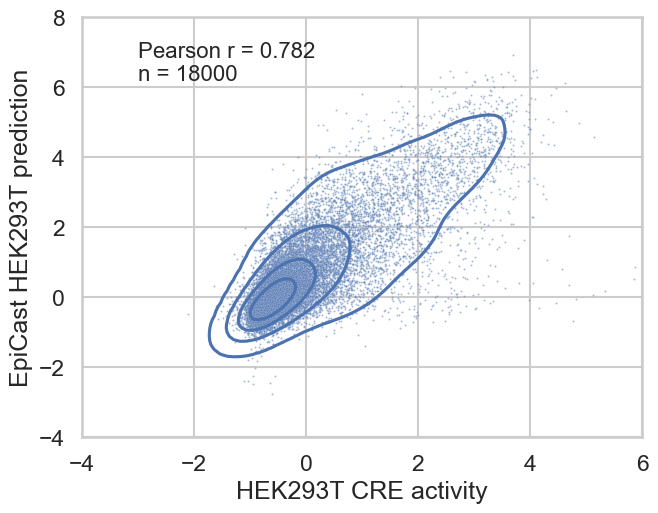

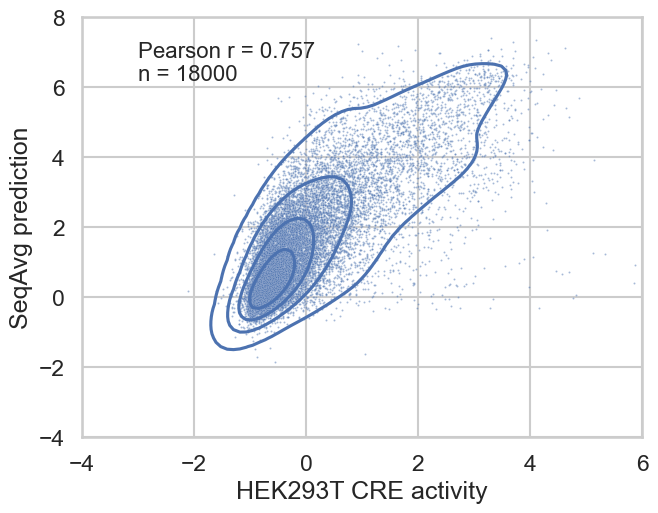

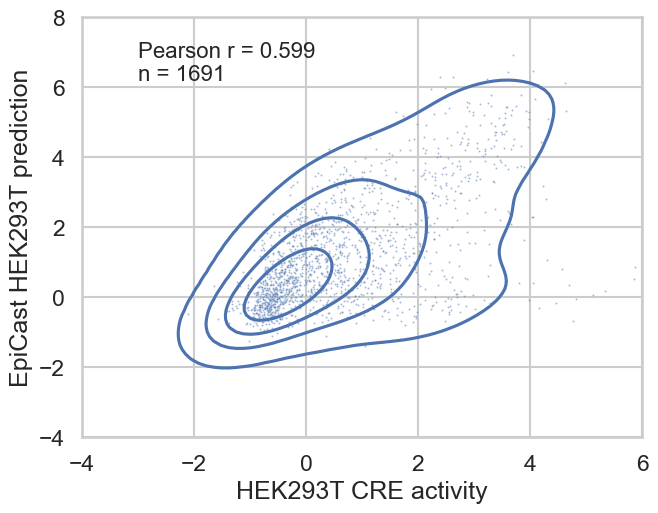

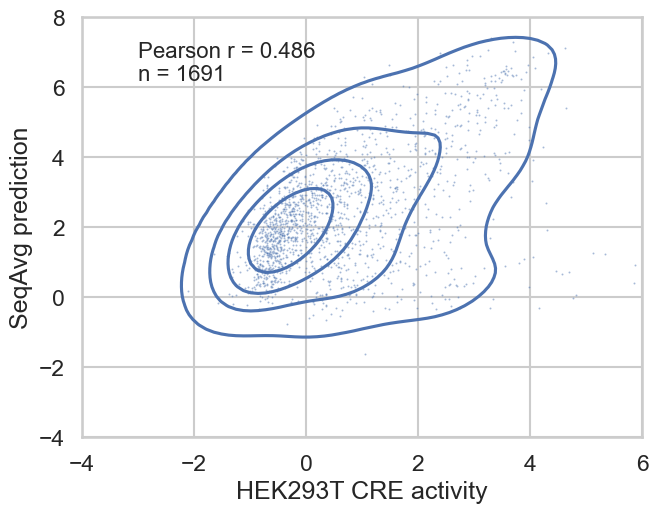

In [10]:
for data_split in ['total', 'HH_specific']:
    pearson_df = pd.DataFrame()
    for cell_type in cell_types[1:2]:
        if data_split in ['specific', 'high', 'low']:
            cond = data_split_dict[f'{cell_type}_{data_split}']
        else:
            cond = data_split_dict[data_split]

        x = MPRA_df.loc[cond, f'{cell_type}']
        y = MPRA_df.loc[cond, f'{cell_type}_pred']
        r, p = pearson(x, y)

        sns.set_theme(style="whitegrid", context="talk")  # 统一风格
        fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
        plt.subplots_adjust(left=0.2, bottom=0.2, right=0.9, top=0.9)

        sns.scatterplot(x=x, y=y, ax=ax, s=2, alpha=0.5, rasterized=True)
        sns.kdeplot(x=x, y=y, ax=ax, levels=5, bw_adjust=1.5, gridsize=100)
        ax.text(0.1, 0.85, f'Pearson r = {r:.3f}\nn = {len(x)}', transform=ax.transAxes, fontsize=16)
        ax.set_xlim(-4, 6)
        ax.set_ylim(-4, 8)
        ax.set_xlabel(f'{cell_type} CRE activity')
        ax.set_ylabel(f'EpiCast {cell_type} prediction')
        plt.savefig(f'figures/TFBU_MPRA_ExpCast_pred_{cell_type}_{data_split}_scatter.png', dpi=400)
        plt.savefig(f'figures_pdf/TFBU_MPRA_ExpCast_pred_{cell_type}_{data_split}_scatter.pdf', dpi=400)
        plt.show()



        x = MPRA_df.loc[cond, f'{cell_type}']
        y = MPRA_df.loc[cond, f'mean_pred']
        r, p = pearson(x, y)

        sns.set_theme(style="whitegrid", context="talk")  # 统一风格
        fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
        plt.subplots_adjust(left=0.2, bottom=0.2, right=0.9, top=0.9)

        sns.scatterplot(x=x, y=y, ax=ax, s=2, alpha=0.5, rasterized=True)
        sns.kdeplot(x=x, y=y, ax=ax, levels=5, bw_adjust=1.5, gridsize=100)
        ax.text(0.1, 0.85, f'Pearson r = {r:.3f}\nn = {len(x)}', transform=ax.transAxes, fontsize=16)
        ax.set_xlim(-4, 6)
        ax.set_ylim(-4, 8)
        ax.set_xlabel(f'{cell_type} CRE activity')
        ax.set_ylabel(f'SeqAvg prediction')
        plt.savefig(f'figures/TFBU_MPRA_SeqAvg_pred_{cell_type}_{data_split}_scatter.png', dpi=400)
        plt.savefig(f'figures_pdf/TFBU_MPRA_SeqAvg_pred_{cell_type}_{data_split}_scatter.pdf', dpi=400)
        plt.show()

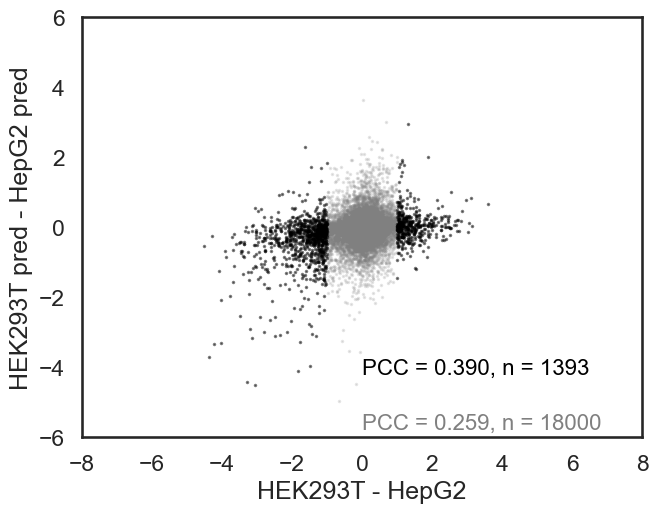

In [15]:
cond_0 = data_split_dict['total']
df = MPRA_df.loc[cond_0]

c1 = 'HEK293T'
c2 = 'HepG2'


sns.set_theme('talk', 'white')
plt.figure(figsize=(8, 6), dpi=100)
plt.subplots_adjust(left=0.2, bottom=0.2, right=0.9, top=0.9)

x = df[f'{c1}'] - df[f'{c2}']
y = df[f'{c1}_pred'] - df[f'{c2}_pred']

x_1 = x[x.abs() < 1]
y_1 = y[x.abs() < 1]
x_2 = x[x.abs() >= 1]
y_2 = y[x.abs() >= 1]

scatter = plt.scatter(x_1, y_1, s=1, c='gray', alpha=0.2)
scatter = plt.scatter(x_2, y_2, s=1, c='black', alpha=0.5)

r = pearson(x, y)[0]
r_2 = pearson(x_2, y_2)[0]
plt.text(
    x=0.5, y=0.02, transform=plt.gca().transAxes, fontsize=16,
    s=f'PCC = {r:.3f}, n = {len(x)}', color='gray',
)

plt.text(
    x=0.5, y=0.15, transform=plt.gca().transAxes, fontsize=16,
    s=f'PCC = {r_2:.3f}, n = {len(x_2)}', color='black',
)


plt.xlabel(f'{c1} - {c2}')
plt.ylabel(f'{c1} pred - {c2} pred')
plt.xlim([-8, 8])
plt.ylim([-6, 6])
plt.savefig(f'figures/Gosai_MPRA_EpiCast_{c1}-{c2}_scatter.png', dpi=400)
plt.savefig(f'figures_pdf/Gosai_MPRA_EpiCast_{c1}-{c2}_scatter.pdf', dpi=400)
plt.show()

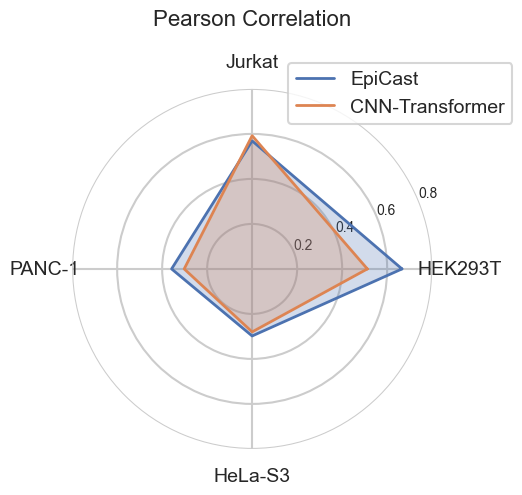

In [66]:
# import numpy as np
# import matplotlib.pyplot as plt

# # 数据
# labels = ['HEK293T', 'Jurkat', 'PANC-1', 'HeLa-S3']
# models = ['EpiCast', 'CNN-Transformer']

# values = np.array([
#     [0.666, 0.569, 0.358, 0.298],  # EpiCast
#     [0.512, 0.592, 0.302, 0.280],  # CNN-Transformer
# ])

# # 闭合雷达图曲线
# num_vars = len(labels)
# angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False)
# angles = np.concatenate((angles, [angles[0]]))

# values_closed = np.concatenate((values, values[:, [0]]), axis=1)

# # 绘图
# sns.set_theme(style="white", context="talk")
# plt.figure(figsize=(6, 6), dpi=100)

# ax = plt.subplot(111, polar=True)
# plt.subplots_adjust(left=0.2, bottom=0.2, right=0.8, top=0.8)

# # 绘制每个模型
# for i in range(values.shape[0]):
#     ax.plot(angles, values_closed[i], linewidth=2, label=models[i])
#     ax.fill(angles, values_closed[i], alpha=0.25)

# # 设置雷达图刻度
# ax.set_xticks(angles[:-1])
# ax.set_xticklabels(labels, fontsize=14)
# ax.spines['polar'].set_visible(False)

# ax.set_ylim(0, 0.8)
# ax.set_yticks([0.2, 0.4, 0.6, 0.8])
# ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8'], fontsize=10)


# # 图例
# plt.legend(loc='upper right', fontsize=14, bbox_to_anchor=(1.25, 1.10))
# plt.title("Pearson Correlation", fontsize=16, pad=20)

# plt.savefig('figures/Gosai_MPRA_EpiCast_TFBU.png', dpi=400)
# plt.savefig('figures_pdf/Gosai_MPRA_EpiCast_TFBU.pdf', dpi=400)
# plt.show()


              HepG2  HEK293T  Jurkat  PANC-1  HeLa-S3
HepG2_pred    0.758    0.754   0.716   0.701    0.641
HEK293T_pred  0.723    0.779   0.724   0.710    0.628
Jurkat_pred   0.694    0.744   0.737   0.717    0.638
PANC-1_pred   0.720    0.749   0.711   0.730    0.649
HeLa-S3_pred  0.718    0.746   0.726   0.724    0.657


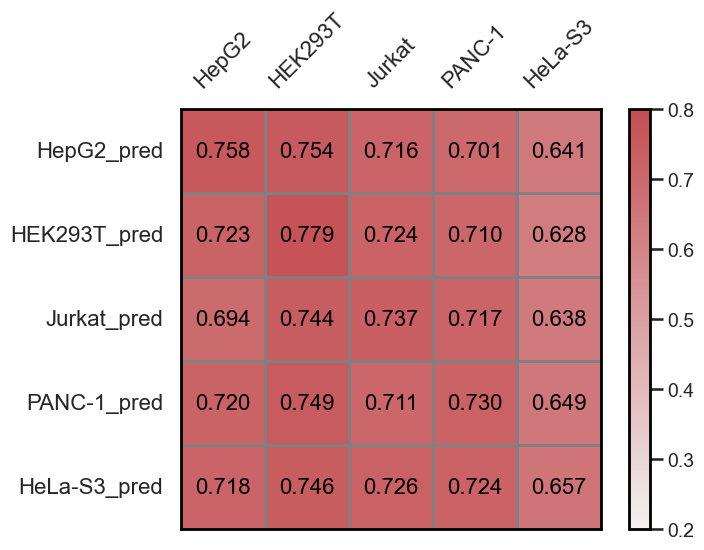

              HepG2  HEK293T  Jurkat  PANC-1  HeLa-S3
HepG2_pred    0.531    0.429   0.425   0.093    0.134
HEK293T_pred  0.449    0.600   0.458   0.110    0.128
Jurkat_pred   0.309    0.397   0.471   0.279    0.328
PANC-1_pred   0.401    0.397   0.398   0.298    0.299
HeLa-S3_pred  0.354    0.372   0.472   0.245    0.309


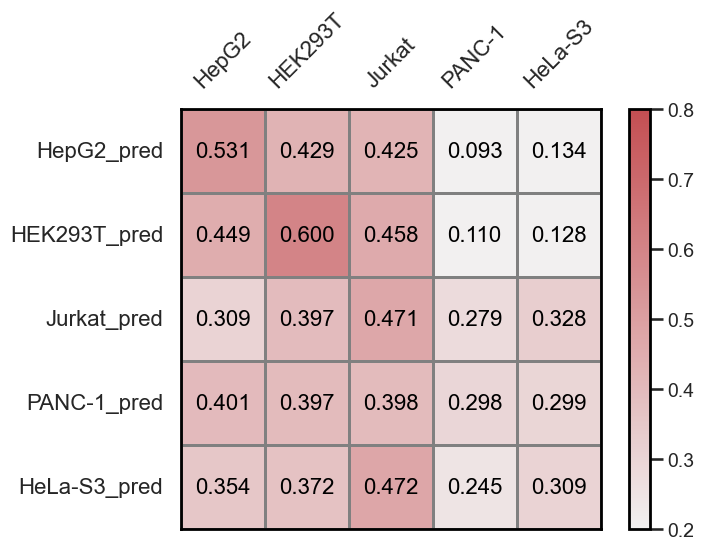

In [30]:
# for data_split in ['total', 'diff']:

#     pearson_df = pd.DataFrame()
#     for ct1 in cell_types:
#         for ct2 in cell_types:
#             cond = data_split_dict[data_split]
#             x = MPRA_df.loc[cond, f'{ct1}_pred']
#             y = MPRA_df.loc[cond, f'{ct2}']
#             r, p = pearson(x, y)
#             pearson_df.loc[f'{ct1}_pred', f'{ct2}'] = r
#     print(pearson_df)






#     # === 图形配置 ===
#     sns.set_theme(style="white", context="talk")  # 统一风格
#     fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
#     plt.subplots_adjust(left=0.2, bottom=0.1, right=0.9, top=0.8)

#     # === 热图绘制 ===
#     sns_plot = sns.heatmap(
#         pearson_df,
#         cmap=sns.color_palette("light:r", as_cmap=True),
#         vmin=0.2,
#         vmax=0.8,
#         square=True,
#         annot=True,
#         fmt=".3f",
#         annot_kws={"size": 16, "color": "black"},
#         cbar=True,
#         linewidths=1,
#         linecolor="gray",
#         ax=ax
#     )

#     # === 坐标轴美化 ===
#     ax.xaxis.tick_top()
#     ax.xaxis.set_label_position("top")
#     ax.tick_params(axis="x", top=False, bottom=False)
#     ax.set_xticklabels(ax.get_xticklabels(), fontsize=16, rotation=45)
#     ax.set_yticklabels(ax.get_yticklabels(), fontsize=16, rotation=0)

#     # === 边框设置 ===
#     for spine in ax.spines.values():
#         spine.set_visible(True)
#         spine.set_linewidth(2)
#         spine.set_edgecolor("black")

#     # === 色条（colorbar）设置 ===
#     cbar = sns_plot.collections[0].colorbar
#     cbar.outline.set_linewidth(2)
#     cbar.outline.set_edgecolor("black")
#     # cbar.set_ticks([0.2, 0.4, 0.6, 0.8, 1.0])
#     cbar.ax.tick_params(labelsize=14)

#     # === 输出 ===
#     plt.savefig(f'figures/TFBU_MPRA_pred_vs_true_{data_split}_heatmap.png', dpi=400)
#     plt.show()